<center>

# DSC680 Applied Data Science 

## Week 7

## Term Project - 2

## Smart Healthcare Operations: Leveraging AI for Efficient Staff Allocation and Patient Care

### Karthika Velingiri

### 06-Feburary-2026

</center>

C:\Users\karth\AppData\Local\Temp\ipykernel_25436\1844770294.py:45: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
C:\Users\karth\AppData\Local\Temp\ipykernel_25436\1844770294.py:46: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)


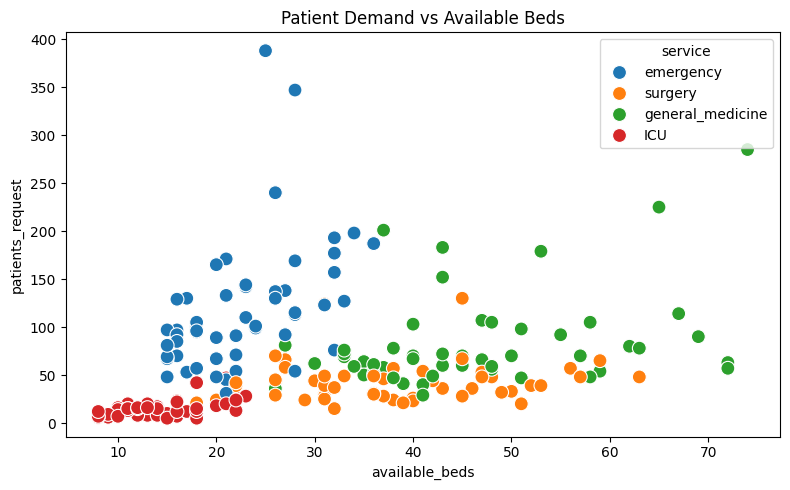

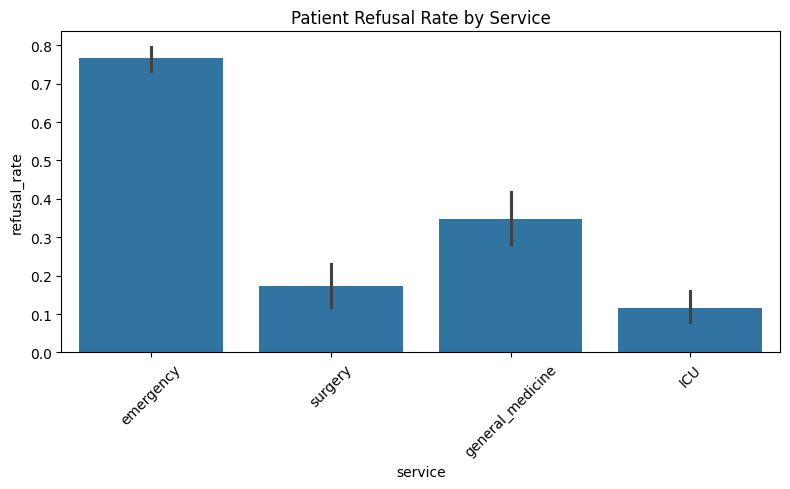

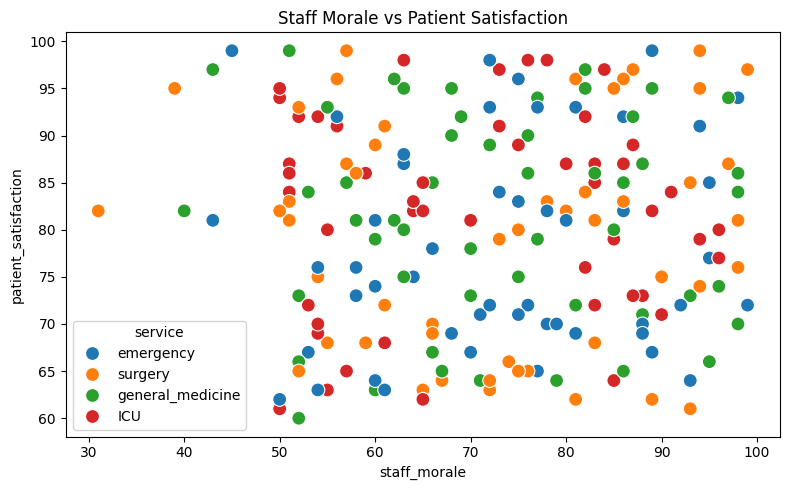

Feature,Impact
available_beds,1.0
wait_pressure,1.0
staff_morale,-0.0
month,-0.0


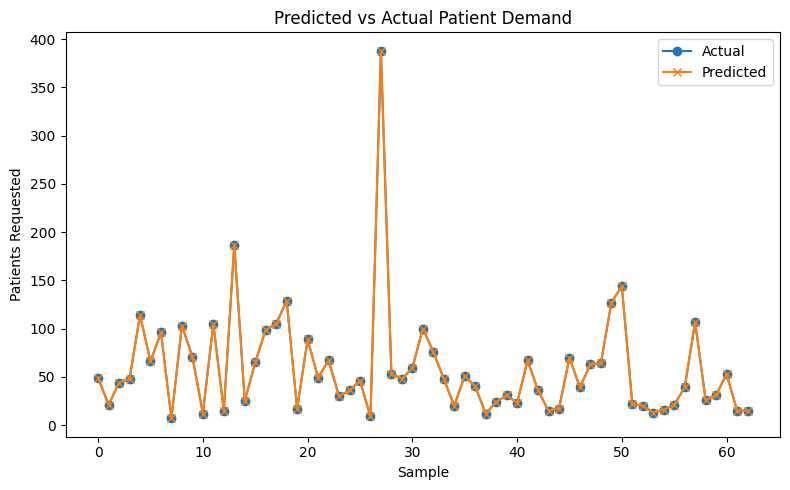

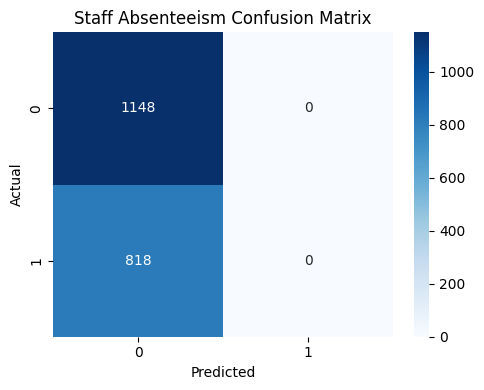

service,patients_request,predicted_demand,refusal_rate,estimated_refusal_reduction
emergency,76,79.2,0.58,-3.2
surgery,130,134.5,0.65,-4.5
general_medicine,201,204.7,0.82,-3.7
ICU,31,33.2,0.29,-2.2
emergency,169,171.8,0.83,-2.8


service,patients_request,predicted_demand,refusal_rate,estimated_refusal_reduction
emergency,76,76.0,0.58,0.0
surgery,130,130.0,0.65,0.0
general_medicine,201,201.0,0.82,0.0
ICU,31,31.0,0.29,-0.0
emergency,169,169.0,0.83,0.0


service,patients_request,predicted_demand,refusal_rate,estimated_refusal_reduction
emergency,76,79.2,0.58,-3.2
surgery,130,134.5,0.65,-4.5
general_medicine,201,204.7,0.82,-3.7
ICU,31,33.2,0.29,-2.2
emergency,169,171.8,0.83,-2.8


service,length_of_stay
ICU,7.61
emergency,7.16
general_medicine,7.00
surgery,7.87


service,wait_pressure_patients,wait_pressure_pct,refusal_rate
ICU,0.33,2.20,0.12
emergency,96.31,422.62,0.77
general_medicine,35.88,77.62,0.35
surgery,5.58,14.86,0.17


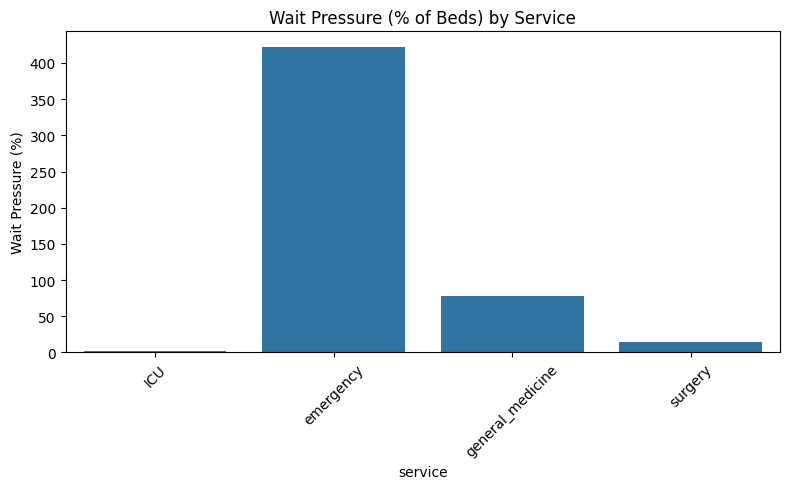

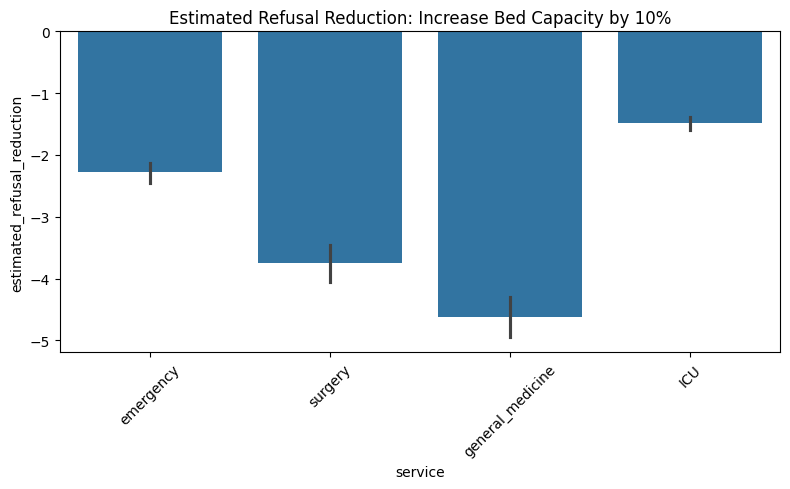

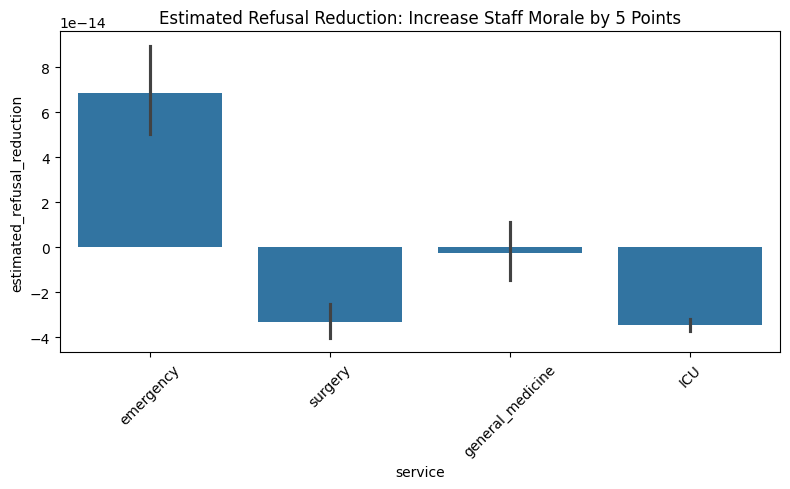

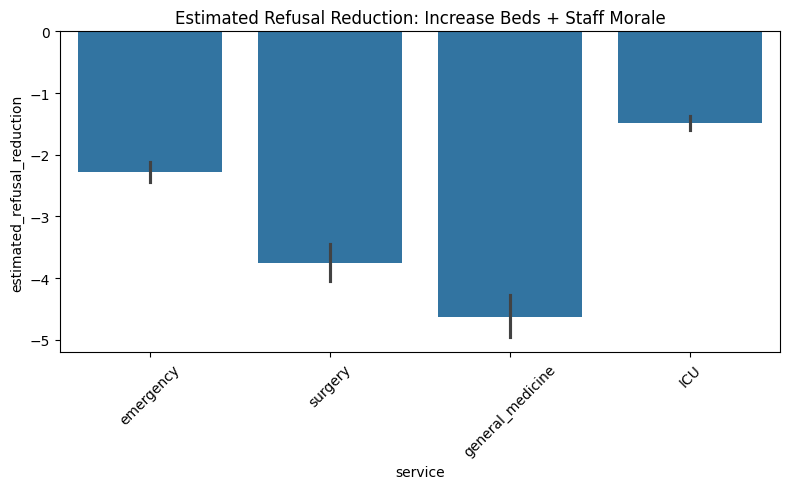

In [8]:
# ==========================================================
# Smart Healthcare Operations
# Predictive & Prescriptive Analytics
# ==========================================================

# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# -------------------------
# Paths
# -------------------------
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
APPENDIX_DIR = BASE_DIR / "appendix"

FIG_DIR.mkdir(exist_ok=True)
APPENDIX_DIR.mkdir(exist_ok=True)

# -------------------------
# Load Data
# -------------------------
patients = pd.read_csv(DATA_DIR / "patients.csv")
staff = pd.read_csv(DATA_DIR / "staff.csv")
services = pd.read_csv(DATA_DIR / "services_weekly.csv")
schedule = pd.read_csv(DATA_DIR / "staff_schedule.csv")

# -------------------------
# Data Preparation
# -------------------------

# Handle dates safely
patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)

# Compute patient length of stay
patients["length_of_stay"] = (patients["departure_date"] - patients["arrival_date"]).dt.days

# Service-level metrics
services["refusal_rate"] = services["patients_refused"] / services["patients_request"]
services["admission_rate"] = services["patients_admitted"] / services["patients_request"]
services["wait_pressure"] = services["patients_request"] - services["available_beds"]

# Staff absenteeism label
schedule["absent"] = np.where(schedule["present"] == 0, 1, 0)

# -------------------------
# Visualizations
# -------------------------

# 1. Patient Demand vs Available Beds
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="available_beds", y="patients_request", hue="service", s=100)
plt.title("Patient Demand vs Available Beds")
plt.tight_layout()
plt.savefig(FIG_DIR / "demand_vs_beds.png")
plt.show()

# 2. Refusal Rate by Service
plt.figure(figsize=(8,5))
sns.barplot(data=services, x="service", y="refusal_rate")
plt.title("Patient Refusal Rate by Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "refusal_rate_by_service.png")
plt.show()

# 3. Staff Morale vs Patient Satisfaction
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="staff_morale", y="patient_satisfaction", hue="service", s=100)
plt.title("Staff Morale vs Patient Satisfaction")
plt.tight_layout()
plt.savefig(FIG_DIR / "morale_vs_satisfaction.png")
plt.show()

# -------------------------
# Predictive Model: Patient Demand
# -------------------------
FEATURES = ["available_beds", "staff_morale", "month", "wait_pressure"]
X = services[FEATURES]
y = services["patients_request"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
display(HTML(f"<h3>Patient Demand Forecast MAE: {mae:.2f}</h3>"))

# Feature importance
feature_impact = pd.DataFrame({"Feature": FEATURES, "Impact": reg_model.coef_}).sort_values(by="Impact", ascending=False)
display(HTML("<h3>Patient Demand Feature Impact</h3>"))
display(HTML(feature_impact.round(2).to_html(index=False)))

# # -------------------------
# # Wait Pressure vs Predicted Demand
# # -------------------------
# services["predicted_demand"] = reg_model.predict(services[FEATURES])

# plt.figure(figsize=(8,5))
# sns.scatterplot(
#     data=services,
#     x="wait_pressure",
#     y="predicted_demand",
#     hue="service",
#     s=100,
#     palette="Set2"
# )
# plt.xlabel("Wait Pressure (Patients Request - Available Beds)")
# plt.ylabel("Predicted Patient Demand")
# plt.title("Impact of Wait Pressure on Predicted Demand")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(FIG_DIR / "wait_pressure_vs_predicted_demand.png")
# plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(8,5))
plt.plot(range(len(y_test)), y_test.values, marker='o', label="Actual")
plt.plot(range(len(y_pred)), y_pred, marker='x', label="Predicted")
plt.title("Predicted vs Actual Patient Demand")
plt.xlabel("Sample")
plt.ylabel("Patients Requested")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "predicted_vs_actual_demand.png")
plt.show()


# -------------------------
# Predictive Model: Staff Absenteeism
# -------------------------
staff_weekly = schedule.merge(staff, on=["staff_id", "staff_name", "role", "service"], how="left")
le = LabelEncoder()
staff_weekly["service_enc"] = le.fit_transform(staff_weekly["service"])
staff_weekly["role_enc"] = le.fit_transform(staff_weekly["role"])

X_clf = staff_weekly[["week", "service_enc", "role_enc"]]
y_clf = staff_weekly["absent"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
display(HTML(f"<h3>Staff Absenteeism Prediction Accuracy: {accuracy:.2f}</h3>"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Staff Absenteeism Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "absenteeism_confusion_matrix.png")
plt.show()

# -------------------------
# Prescriptive Analysis Scenarios
# -------------------------
scenarios = []

# Scenario 1: Increase bed capacity by 10%
scenario1 = services.copy()
scenario1["available_beds"] = scenario1["available_beds"] * 1.10
scenario1["predicted_demand"] = reg_model.predict(scenario1[FEATURES])
scenario1["estimated_refusal_reduction"] = scenario1["patients_request"] - scenario1["predicted_demand"]
scenarios.append(("Increase Bed Capacity by 10%", scenario1))

# Scenario 2: Increase staff morale by 5 points
scenario2 = services.copy()
scenario2["staff_morale"] = scenario2["staff_morale"] + 5
scenario2["predicted_demand"] = reg_model.predict(scenario2[FEATURES])
scenario2["estimated_refusal_reduction"] = scenario2["patients_request"] - scenario2["predicted_demand"]
scenarios.append(("Increase Staff Morale by 5 Points", scenario2))

# Scenario 3: Beds + Morale
scenario3 = services.copy()
scenario3["available_beds"] = scenario3["available_beds"] * 1.10
scenario3["staff_morale"] = scenario3["staff_morale"] + 5
scenario3["predicted_demand"] = reg_model.predict(scenario3[FEATURES])
scenario3["estimated_refusal_reduction"] = scenario3["patients_request"] - scenario3["predicted_demand"]
scenarios.append(("Increase Beds + Staff Morale", scenario3))

# Display all prescriptive scenarios
for title, df in scenarios:
    display(HTML(f"<h3>{title}</h3>"))
    display(HTML(
        df[["service","patients_request","predicted_demand","refusal_rate","estimated_refusal_reduction"]].round(2).head().to_html(index=False)
    ))
    # Save table to appendix
    df.to_csv(APPENDIX_DIR / f"{title.replace(' ','_').lower()}.csv", index=False)

# -------------------------
# Patient Flow Metrics
# -------------------------
# Average length of stay by service
los_service = patients.groupby("service")["length_of_stay"].mean().reset_index()
display(HTML("<h3>Average Length of Stay by Service</h3>"))
display(HTML(los_service.round(2).to_html(index=False)))

# # Average wait pressure per service
# wait_pressure_service = services.groupby("service")["wait_pressure"].mean().reset_index()
# display(HTML("<h3>Average Wait Pressure by Service</h3>"))
# display(HTML(wait_pressure_service.round(2).to_html(index=False)))

# -------------------------
# Average Wait Pressure & Operational Metrics per Service
# -------------------------

# Compute average wait pressure per service
wait_pressure_service = services.groupby("service").agg(
    wait_pressure_patients=("wait_pressure", "mean"),
    available_beds=("available_beds", "mean"),
    refusal_rate=("refusal_rate", "mean")
).reset_index()

# Calculate wait pressure as a percentage of available beds
wait_pressure_service["wait_pressure_pct"] = (wait_pressure_service["wait_pressure_patients"] / wait_pressure_service["available_beds"]) * 100

wait_pressure_service = wait_pressure_service[["service", "wait_pressure_patients", "wait_pressure_pct", "refusal_rate"]]


display(HTML("<h3>Average Wait Pressure & Refusal Rate by Service</h3>"))
display(HTML(wait_pressure_service.round(2).to_html(index=False)))

plt.figure(figsize=(8,5))
sns.barplot(data=wait_pressure_service, x="service", y="wait_pressure_pct")
plt.title("Wait Pressure (% of Beds) by Service")
plt.ylabel("Wait Pressure (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "wait_pressure_pct_by_service.png")
plt.show()


# -------------------------
# Additional Visualizations
# -------------------------

# Refusal reduction per scenario (bar plot)
for title, df in scenarios:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x="service", y="estimated_refusal_reduction")
    plt.title(f"Estimated Refusal Reduction: {title}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"refusal_reduction_{title.replace(' ','_').lower()}.png")
    plt.show()
